In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import torchvision.transforms as T
from tqdm import tqdm
import shutil
import glob
from sklearn.model_selection import train_test_split
from torchvision.ops import box_iou
from sklearn.metrics import precision_score, recall_score, f1_score

# Preprocessing

In [3]:
# Paths
images_dir = '/kaggle/input/airplanes/Images/Images'
annotations_dir = '/kaggle/input/airplanes/Airplanes_Annotations/Airplanes_Annotations'

# Find all image and annotation files
image_files = {os.path.splitext(os.path.basename(f))[0]: f for f in glob.glob(f'{images_dir}/*.jpg')}
annotation_files = {os.path.splitext(os.path.basename(f))[0]: f for f in glob.glob(f'{annotations_dir}/*.csv')}

# Find valid pairs
valid_pairs = set(image_files.keys()).intersection(set(annotation_files.keys()))

# Prepare final dataset list
dataset_pairs = [(image_files[k], annotation_files[k]) for k in valid_pairs]

print(f"Found {len(dataset_pairs)} valid image-annotation pairs.")


Found 733 valid image-annotation pairs.


# Dataset Class

In [4]:
class AirplaneDataset(Dataset):
    def __init__(self, dataset_pairs, transforms=None):
        self.dataset_pairs = dataset_pairs
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset_pairs)

    def __getitem__(self, idx):
        image_path, annotation_path = self.dataset_pairs[idx]
        
        # Load image
        img = Image.open(image_path).convert("RGB")
        
        # Load annotations
        annotation = pd.read_csv(annotation_path, header=None)
        
        # Check if the first row indicates zero airplanes
        num_airplanes = int(annotation.iloc[0, 0])
        boxes = []
        
        if num_airplanes > 0:
            # Parse bounding boxes if airplanes are present
            for _, row in annotation.iloc[1:].iterrows():
                coords = list(map(int, row.iloc[0].split()))
                if len(coords) == 4:
                    xmin, ymin, xmax, ymax = coords
                    boxes.append([xmin, ymin, xmax, ymax])
        
        # Prepare labels and handle no airplanes case
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)  # Empty tensor for no bounding boxes
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming all objects are 'airplanes'
        
        target = {
            'boxes': boxes,
            'labels': labels
        }
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target




valid_dataset_pairs = []

for image_path, annotation_path in dataset_pairs:
    annotation = pd.read_csv(annotation_path, header=None)
    num_airplanes = int(annotation.iloc[0, 0])
    
    if num_airplanes > 0:
        valid_dataset_pairs.append((image_path, annotation_path))

print(f"Filtered dataset to {len(valid_dataset_pairs)} valid image-annotation pairs.")


Filtered dataset to 729 valid image-annotation pairs.


# DataLoader Preparation

In [5]:
def collate_fn(batch):
    images = []
    targets = []
    
    for img, tgt in batch:
        images.append(img)
        targets.append(tgt)
    
    return images, targets


dataset_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset with valid pairs
train_pairs, test_pairs = train_test_split(
    valid_dataset_pairs, 
    test_size=0.2, 
    random_state=42
)

print(f"Training Samples: {len(train_pairs)}, Testing Samples: {len(test_pairs)}")


# Define transformations (same for train and test)
dataset_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Training Dataset
train_dataset = AirplaneDataset(train_pairs, transforms=dataset_transforms)

# Testing Dataset
test_dataset = AirplaneDataset(test_pairs, transforms=dataset_transforms)

# Training DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

# Testing DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

# Check a sample batch
images, targets = next(iter(train_loader))
print(f"Batch size: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Number of targets: {len(targets)}")
print(f"First target boxes: {targets[0]['boxes']}")



Training Samples: 583, Testing Samples: 146
Batch size: 4
Image shape: torch.Size([3, 256, 256])
Number of targets: 4
First target boxes: tensor([[  9.,  51.,  59.,  89.],
        [ 38.,  96.,  85., 132.],
        [ 66., 150., 120., 182.],
        [115., 187., 161., 233.]])


# Visualizing Annotations on Images 

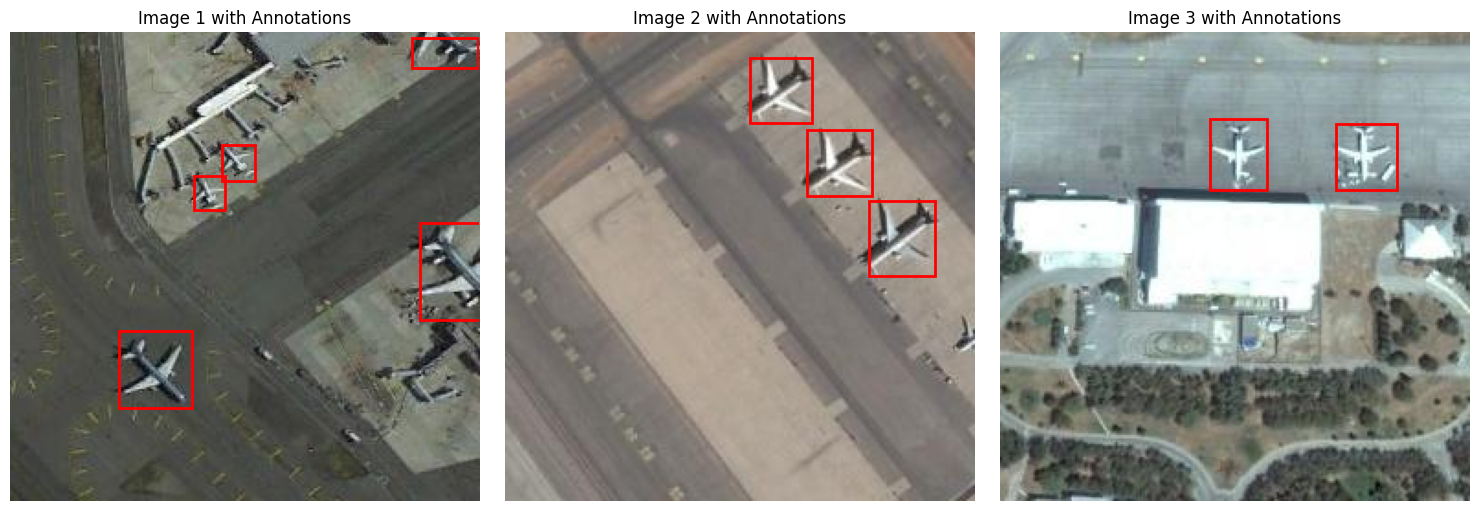

In [6]:
def visualize_annotations(dataset, num_samples=3):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    
    if num_samples == 1:
        axs = [axs]
    
    for i in range(num_samples):
        img, target = dataset[i]
        img = img.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        
        axs[i].imshow(img)
        axs[i].axis('off')
        
        # Plot bounding boxes
        for box in target['boxes']:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            axs[i].add_patch(rect)
        
        axs[i].set_title(f"Image {i+1} with Annotations")
    
    plt.tight_layout()
    plt.show()

visualize_annotations(train_dataset, num_samples=3)


#  Define the Model

In [7]:
# Load Faster R-CNN pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)

# Number of classes: 1 (airplane) + 1 (background)
num_classes = 2

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one for our dataset
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 216MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training parameters

In [8]:
# Optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


# Training loop

In [9]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch+1} Training"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
    
    avg_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}: Average Loss: {avg_loss:.4f}")
    return avg_loss



num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    print(f"Epoch #{epoch + 1} Completed, Loss: {train_loss:.4f}")



Epoch 1 Training: 100%|██████████| 146/146 [01:03<00:00,  2.32it/s]


Epoch 1: Average Loss: 0.3607
Epoch #1 Completed, Loss: 0.3607


Epoch 2 Training: 100%|██████████| 146/146 [01:01<00:00,  2.37it/s]


Epoch 2: Average Loss: 0.2528
Epoch #2 Completed, Loss: 0.2528


Epoch 3 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 3: Average Loss: 0.2263
Epoch #3 Completed, Loss: 0.2263


Epoch 4 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 4: Average Loss: 0.1866
Epoch #4 Completed, Loss: 0.1866


Epoch 5 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 5: Average Loss: 0.1762
Epoch #5 Completed, Loss: 0.1762


Epoch 6 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 6: Average Loss: 0.1711
Epoch #6 Completed, Loss: 0.1711


Epoch 7 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 7: Average Loss: 0.1661
Epoch #7 Completed, Loss: 0.1661


Epoch 8 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 8: Average Loss: 0.1646
Epoch #8 Completed, Loss: 0.1646


Epoch 9 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 9: Average Loss: 0.1640
Epoch #9 Completed, Loss: 0.1640


Epoch 10 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 10: Average Loss: 0.1638
Epoch #10 Completed, Loss: 0.1638


Epoch 11 Training: 100%|██████████| 146/146 [01:01<00:00,  2.35it/s]


Epoch 11: Average Loss: 0.1633
Epoch #11 Completed, Loss: 0.1633


Epoch 12 Training: 100%|██████████| 146/146 [01:02<00:00,  2.35it/s]


Epoch 12: Average Loss: 0.1637
Epoch #12 Completed, Loss: 0.1637


Epoch 13 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 13: Average Loss: 0.1636
Epoch #13 Completed, Loss: 0.1636


Epoch 14 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 14: Average Loss: 0.1630
Epoch #14 Completed, Loss: 0.1630


Epoch 15 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 15: Average Loss: 0.1630
Epoch #15 Completed, Loss: 0.1630


Epoch 16 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 16: Average Loss: 0.1631
Epoch #16 Completed, Loss: 0.1631


Epoch 17 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 17: Average Loss: 0.1624
Epoch #17 Completed, Loss: 0.1624


Epoch 18 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 18: Average Loss: 0.1634
Epoch #18 Completed, Loss: 0.1634


Epoch 19 Training: 100%|██████████| 146/146 [01:01<00:00,  2.36it/s]


Epoch 19: Average Loss: 0.1636
Epoch #19 Completed, Loss: 0.1636


Epoch 20 Training: 100%|██████████| 146/146 [01:02<00:00,  2.35it/s]

Epoch 20: Average Loss: 0.1640
Epoch #20 Completed, Loss: 0.1640


# Evaluate on Test Data

In [10]:


def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    """
    Evaluate Faster R-CNN on test dataset and compute IoU, Precision, Recall, and F1-Score per image.
    Args:
        model: Trained Faster R-CNN model.
        data_loader: DataLoader for test dataset.
        device: Device (CPU or GPU).
        iou_threshold: IoU threshold for considering a prediction as valid.
    Returns:
        metrics: Dictionary with IoU, Precision, Recall, and F1-Score.
    """
    model.eval()
    image_precisions = []
    image_recalls = []
    image_f1s = []
    image_ious = []
    
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                gt_boxes = target['boxes']
                
                if len(pred_boxes) == 0 and len(gt_boxes) == 0:
                    # No predictions and no ground truths
                    image_precisions.append(1.0)  # Perfect precision
                    image_recalls.append(1.0)     # Perfect recall
                    image_f1s.append(1.0)         # Perfect F1
                    image_ious.append(1.0)        # Perfect IoU
                    continue
                
                if len(pred_boxes) == 0:
                    # No predictions but ground truths exist
                    image_precisions.append(0.0)
                    image_recalls.append(0.0)
                    image_f1s.append(0.0)
                    image_ious.append(0.0)
                    continue
                
                if len(gt_boxes) == 0:
                    # Predictions exist but no ground truths
                    image_precisions.append(0.0)
                    image_recalls.append(0.0)
                    image_f1s.append(0.0)
                    image_ious.append(0.0)
                    continue
                
                # Calculate IoU
                iou = box_iou(pred_boxes, gt_boxes)
                matched_preds = (iou.max(dim=1)[0] > iou_threshold).int().cpu().numpy()
                matched_gts = (iou.max(dim=0)[0] > iou_threshold).int().cpu().numpy()
                
                precision = np.sum(matched_preds) / len(pred_boxes.cpu().numpy())
                recall = np.sum(matched_gts) / len(gt_boxes.cpu().numpy())
                f1 = (
                    2 * precision * recall / (precision + recall)
                    if precision + recall > 0 else 0.0
                )
                avg_iou = iou.mean().item()
                
                image_precisions.append(precision)
                image_recalls.append(recall)
                image_f1s.append(f1)
                image_ious.append(avg_iou)
    
    # Calculate overall metrics
    metrics = {
        'Average Precision': np.mean(image_precisions),
        'Average Recall': np.mean(image_recalls),
        'Average F1-Score': np.mean(image_f1s),
        'Average IoU': np.mean(image_ious)
    }
    
    print("\nEvaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    return metrics


test_metrics = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 37/37 [00:07<00:00,  5.04it/s]


Evaluation Metrics:
Average Precision: 0.8661
Average Recall: 0.9867
Average F1-Score: 0.9083
Average IoU: 0.3734


# Visualize Predictions

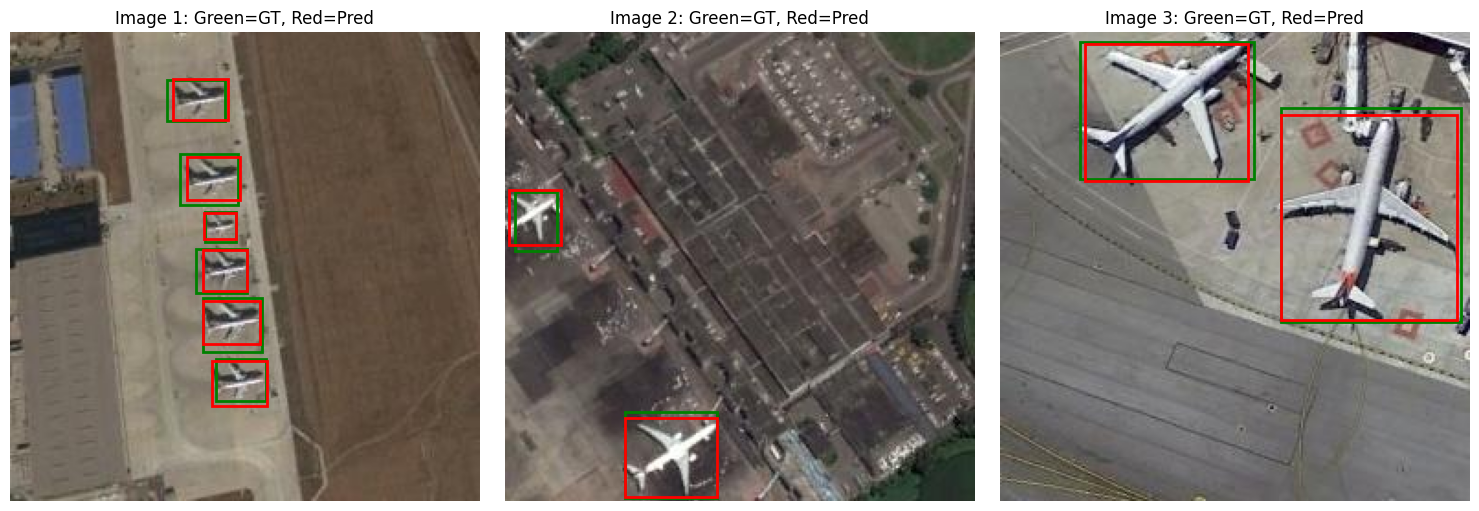

In [11]:
# Cell 19: Visualization Function for Model Predictions

def visualize_predictions(model, dataset, device, num_samples=3, iou_threshold=0.5):

    model.eval()
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    
    if num_samples == 1:
        axs = [axs]
    
    with torch.no_grad():
        for i in range(num_samples):
            img, target = dataset[i]
            img_tensor = img.to(device)
            img_cpu = img_tensor.permute(1, 2, 0).cpu().numpy()
            
            # Run inference on the image
            prediction = model([img_tensor])[0]
            
            axs[i].imshow(img_cpu)
            axs[i].axis('off')
            
            # Plot ground-truth boxes (Green)
            for box in target['boxes']:
                xmin, ymin, xmax, ymax = box.cpu().numpy()
                rect = patches.Rectangle(
                    (xmin, ymin), xmax - xmin, ymax - ymin,
                    linewidth=2, edgecolor='green', facecolor='none'
                )
                axs[i].add_patch(rect)
            
            # Plot predicted boxes (Red) above a confidence threshold
            for score, box in zip(prediction['scores'], prediction['boxes']):
                if score > iou_threshold:
                    xmin, ymin, xmax, ymax = box.cpu().numpy()
                    rect = patches.Rectangle(
                        (xmin, ymin), xmax - xmin, ymax - ymin,
                        linewidth=2, edgecolor='red', facecolor='none'
                    )
                    axs[i].add_patch(rect)
            
            axs[i].set_title(f"Image {i+1}: Green=GT, Red=Pred")
    
    plt.tight_layout()
    plt.show()


visualize_predictions(model, test_dataset, device, num_samples=3)


# Calculate Mean Average Precision (mAP)

In [12]:

def calculate_map(model, data_loader, device):
    model.eval()
    avg_precision = 0.0
    num_images = 0
    
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Calculating mAP"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                gt_boxes = target['boxes']
                
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    iou = box_iou(pred_boxes, gt_boxes)
                    avg_precision += (iou > 0.5).float().mean().item()
                    num_images += 1
    
    map_score = avg_precision / num_images if num_images > 0 else 0.0
    print(f"Mean Average Precision (mAP@0.5): {map_score:.4f}")
    return map_score

# Calculate mAP
map_score = calculate_map(model, test_loader, device)
print(map_score)

Calculating mAP: 100%|██████████| 37/37 [00:07<00:00,  5.14it/s]

Mean Average Precision (mAP@0.5): 0.4347
0.434693060674998
